In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn import datasets
from sklearn.model_selection import train_test_split

import datetime
from dateutil.parser import parse

%matplotlib inline

### BayWheel Station Optimization 
#### Niva Alina Ran

This project looks at the BayWheel bikesharing dataset (source: https://www.lyft.com/bikes/bay-wheels/system-data). 
I use the per-station usage data to construct a predictive model, which for a given geo-coordinate in San Francisco, predicts the expected monthly demand. I then use this predictive model to optimize for the placement of bike stations with the objectibve of minimized total expected walking distances, weighted by demand density. 

In [13]:
#Load data
df_raw = pd.read_csv("201910-baywheels-tripdata.csv")
print(df_raw.columns)
df_raw.head(2)

Index(['duration_sec', 'start_time', 'end_time', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type',
       'member_birth_year', 'member_gender', 'bike_share_for_all_trip'],
      dtype='object')


,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,62337,2019-10-31 16:25:01.5970,2019-11-01 09:43:59.0290,148,Horton St at 40th St,37.829705,-122.28761,385,Woolsey St at Sacramento St,37.850578,-122.278175,12222,Customer,NaN,NaN,No
1,72610,2019-10-31 13:04:11.1950,2019-11-01 09:14:21.8050,376,Illinois St at 20th St,37.760458,-122.38754,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,282,Customer,NaN,NaN,No


In [14]:
## Add hour of day and day of week features
dt_vec = df_raw['start_time'].apply(lambda x: parse(x))
hod_col = dt_vec.apply(lambda x: x.hour)
dow_col = dt_vec.apply(lambda x: x.weekday())
    
df_raw["start_hour_of_day"] = hod_col
df_raw["start_day_of_week"] = dow_col

### Exploratory Data Analysis

In [15]:
### Create new data set, grouped by station
df=df_raw
df_stat = pd.DataFrame([])
station_id_list = np.sort(df["start_station_id"].unique())
df_stat["station_id"] = station_id_list
df_stat["start_station_latitude"]  = df_stat["station_id"].apply(lambda x: float(df_raw[df_raw["start_station_id"] == x].head(1)["start_station_latitude"]))
df_stat["start_station_longitude"] = df_stat["station_id"].apply(lambda x: float(df_raw[df_raw["start_station_id"] == x].head(1)["start_station_longitude"]))
df_stat["start_trip_count"] = df_stat["station_id"].apply(lambda x: len(df_raw[df_raw["start_station_id"] == x]))

In [16]:
### Visualize bike usage by starting station
from folium import plugins
import folium as folium
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

m = folium.Map([37.7756925, -122.4204695], zoom_start=13)
# convert to (n, 2) nd-array format for heatmap
station_data = df_stat[['start_station_latitude', 'start_station_longitude', 'start_trip_count']].values

## Convert startig trip count to quantiles for visualization
d = station_data[:,2]
qrange = np.arange(0,100,1.25)
quantiles = np.percentile(d, qrange)
station_data[:,2] = np.searchsorted(quantiles, d)/len(qrange)

# plot heatmap
m.add_child(plugins.HeatMap(station_data, max_zoom = 13, max_val=1, radius = 8, blur=2))

### Learning a bike demand distribution map using K-nearest neighbors

In [17]:
from sklearn.neighbors import KNeighborsRegressor

station_data = df_stat[['start_station_latitude', 'start_station_longitude', 'start_trip_count']].values
X = station_data[:,[0, 1]]
y = station_data[:,2]
neigh = KNeighborsRegressor(n_neighbors=4, weights = 'distance')
neigh.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='distance')

In [18]:
## Define grid coordinate range
coor_ll = np.array([37.748566, -122.477034]) #lower left coordinate
coor_ur = np.array([37.801819, -122.389905]) #upper right coordiante
grid_size = 30 #number of points on each side of the grid

grid_lat, grid_long = np.mgrid[coor_ll[0]:coor_ur[0]:(coor_ur[0]-coor_ll[0])/grid_size, coor_ll[1]:coor_ur[1]:(coor_ur[1]-coor_ll[1])/grid_size] 
grid_lat = np.ndarray.flatten(grid_lat)
grid_long = np.ndarray.flatten(grid_long)

# Predicting Demand
X = np.stack((grid_lat, grid_long), axis= -1)
y_pred = np.transpose(neigh.predict(X))
grid_data = np.stack((grid_lat, grid_long, y_pred), axis=-1)

## Convert startig trip count to quantiles for visualization
d = grid_data[:,2]
qrange = np.arange(0,100,1.25)
quantiles = np.percentile(d, qrange)
grid_data[:,2] = np.searchsorted(quantiles, d)/len(qrange)

# Visualization with map
cor_ref_start = (coor_ll+coor_ur)/2
m = folium.Map(cor_ref_start, zoom_start=13)

# plot heatmap
m.add_child(plugins.HeatMap(grid_data, max_zoom = 13, max_val=1, radius = 5, blur=1))
m

## Part 2: Station Optimization using Evolutionary Strategy

In [19]:
#Define distance measure between two points
def manhattan_distance(a,b): 
    return np.sum(np.absolute(a-b))

def geo_vec_to_tab(geo_vec):
    n_stat = int(len(geo_vec)/2)
    return np.stack((geo_vec[0:n_stat],geo_vec[n_stat:2*n_stat]), axis= -1)

# primary data structure for SGD optimization
class bay_wheel_station_opt: 
    def __init__(self, grid_data):
        self.geo_coords = grid_data["geo_coords"]
        self.demand = grid_data["demand"]
        
    def eval(self, stat_geo_list_vec):
        # for each unit of demand, let cost be the Manhattan distance to the nearest station
        # station geo list is a vector [Lat...., Long....]
        tot_cost = 0
        n_stat = int(len(stat_geo_list_vec)/2)
        stat_geo_list_table = np.stack((stat_geo_list_vec[0:n_stat],stat_geo_list_vec[n_stat:2*n_stat]), axis= -1)
        
        for n in range(len(self.demand)):
            x = self.geo_coords[n,]
            dis_vec = np.zeros(n_stat)
            for i in range(len(dis_vec)): 
                dis_vec[i] = manhattan_distance(x,stat_geo_list_table[i,])
            tot_cost = tot_cost+np.min(dis_vec)*self.demand[n]
        return tot_cost
    


In [20]:
## Stochastic gradient descent using Evolutionary Strategy

def es_optimize(funct, x_init, es_coef): 
    #funct: function class object
    #x_init: array, initial solution
    #es_coef: optimization coefficients    
        # "n": number of steps
        # "m": nubmer of mutations
        # "alpha" :  step size parameter
        # "sigma" : search distribution variance
    
    n = es_coef["n"]
    m = es_coef["m"]
    alpha = es_coef["alpha"]
    sigma = es_coef["sigma"]
    xlim_u = es_coef["xlim_u"]
    xlim_l = es_coef["xlim_l"]

    p = len(x_init) #dimension of the solution
    
    ## Initialization
    x = np.zeros([n, p])
    y = np.zeros([n, p])
    y_muta = np.zeros(m)

    x[0,]=x_init
    y[0] =  funct.eval(x[0,])
    
    for i in range(n-1):
        c_sum = np.zeros(p)
        d_muta = np.random.normal(0, sigma, [m,p]) #Generate mutations

        #Estimate gradient using weighted mutations
        for j in range(m):
            y_muta[j] = funct.eval(x[i,]+d_muta[j,])
            c_sum = c_sum + (y_muta[j]-y[i])*d_muta[j,]

        #Update solutions using estimated gradient
        x_now = x[i,]- c_sum*alpha/(sigma**2*m)

        x_now = np.minimum(xlim_u, x_now)
        x_now = np.maximum(xlim_l, x_now)
        
        x[i+1,] = x_now
        y[i+1] = funct.eval(x[i+1,])
        
    results = {
        "x_vec": x,
        "y_vec": y,
        "final_x": x[n-1,]
    }
        
    return results

In [21]:
n_station = 40

xlim_u = np.concatenate((np.ones(n_station)*coor_ur[0], np.ones(n_station)*coor_ur[1]))

xlim_l = np.concatenate((np.ones(n_station)*coor_ll[0], np.ones(n_station)*coor_ll[1]))

es_coef = {
"n": 60, # number of steps
"m": 7, # nubmer of mutations
"alpha" :  0.000000009, # step size parameter
"sigma" : 0.0000000001, #search distribution variance
"xlim_u" : xlim_u,
"xlim_l" : xlim_l,
}

grid_data = {
    "geo_coords" : np.stack((grid_lat, grid_long), axis= -1),
    "demand" : y_pred
}

## Initalize optimization objective function 
bw_station_opt = bay_wheel_station_opt(grid_data)

## Set initial station placement 
geo_coords = grid_data["geo_coords"]
init_ind=np.random.randint(len(grid_data["geo_coords"]), size=(n_station, 2))
x_init = np.zeros([n_station,2])
for i in range(n_station):
    x_init[i,] = geo_coords[init_ind][i][0]
x_init = np.ndarray.flatten(x_init, 'F')

## Optmize using Evolutionary Strategy
results = es_optimize(bw_station_opt,x_init, es_coef)

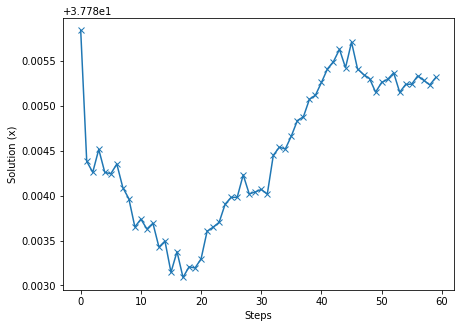

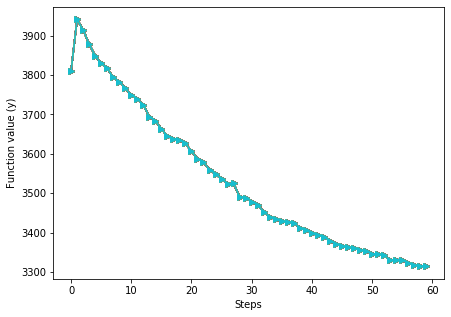

[  37.78531827   37.75099488   37.7668832    37.77951462   37.79055288
   37.75226656   37.78732951   37.78776516   37.77023514   37.78219237
   37.76737838   37.75535161   37.76289      37.75078079   37.75562234
   37.79170628   37.76982049   37.76230129   37.78060972   37.75050991
   37.78178489   37.76324787   37.78602499   37.7764988    37.78229461
   37.75237036   37.76189626   37.79289233   37.79656255   37.79320399
   37.79242948   37.79906376   37.77511641   37.78949406   37.75997351
   37.77350182   37.77503782   37.76753872   37.78450697   37.76278555
 -122.40660552 -122.46448917 -122.45669314 -122.42500341 -122.4768417
 -122.43503693 -122.3928528  -122.4015141  -122.43461397 -122.41190195
 -122.47187561 -122.42013731 -122.45290896 -122.47194407 -122.45417607
 -122.40316523 -122.45444193 -122.42450457 -122.44830055 -122.41699845
 -122.45727868 -122.44516126 -122.4104032  -122.39578798 -122.44235098
 -122.44389833 -122.39507443 -122.39584477 -122.39472679 -122.42788921
 -122.4

In [22]:
x_vec = results["x_vec"]
y_vec = results["y_vec"]
final_x = results["final_x"]

plt.figure(figsize=(7,5))
plt.plot(x_vec[:,0],'-x');
plt.ylabel("Solution (x)")
plt.xlabel("Steps");
plt.show()

plt.figure(figsize=(7,5));
plt.plot(y_vec,'->');
plt.ylabel("Function value (y)")
plt.xlabel("Steps");
plt.show()

print(final_x)

In [23]:
##### Visualization with map
final_station_geos = geo_vec_to_tab(final_x)
cor_ref_start = (coor_ll+coor_ur)/2
m = folium.Map(cor_ref_start, zoom_start=13)

# plot heatmap of new stations
m.add_child(plugins.HeatMap(final_station_geos, max_zoom = 13, max_val=1, radius = 13, blur=1))

## Comparison
grid_data = np.stack((grid_lat, grid_long, y_pred), axis=-1)
## Convert startig trip count to quantiles for visualization
d = grid_data[:,2]
qrange = np.arange(0,100,1.25)
quantiles = np.percentile(d, qrange)
grid_data[:,2] = np.searchsorted(quantiles, d)/len(qrange)
#m.add_child(plugins.HeatMap(grid_data, max_zoom = 13, max_val=1, radius = 3, blur=1))
m.add_child(plugins.HeatMap(station_data, max_zoom = 13, max_val=1, radius = 6, blur=2))
m